In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('calories.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


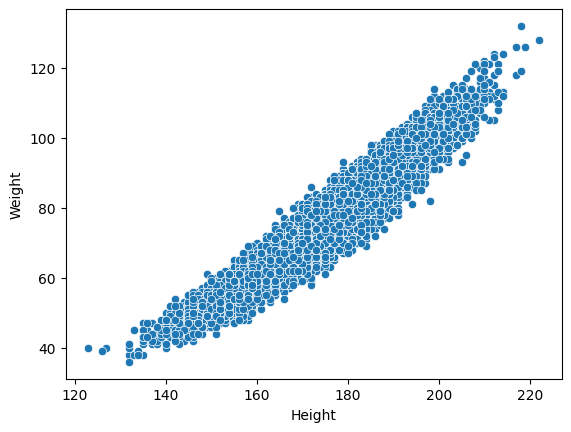

In [3]:
sb.scatterplot(x='Height', y='Weight', data=df)
plt.show()



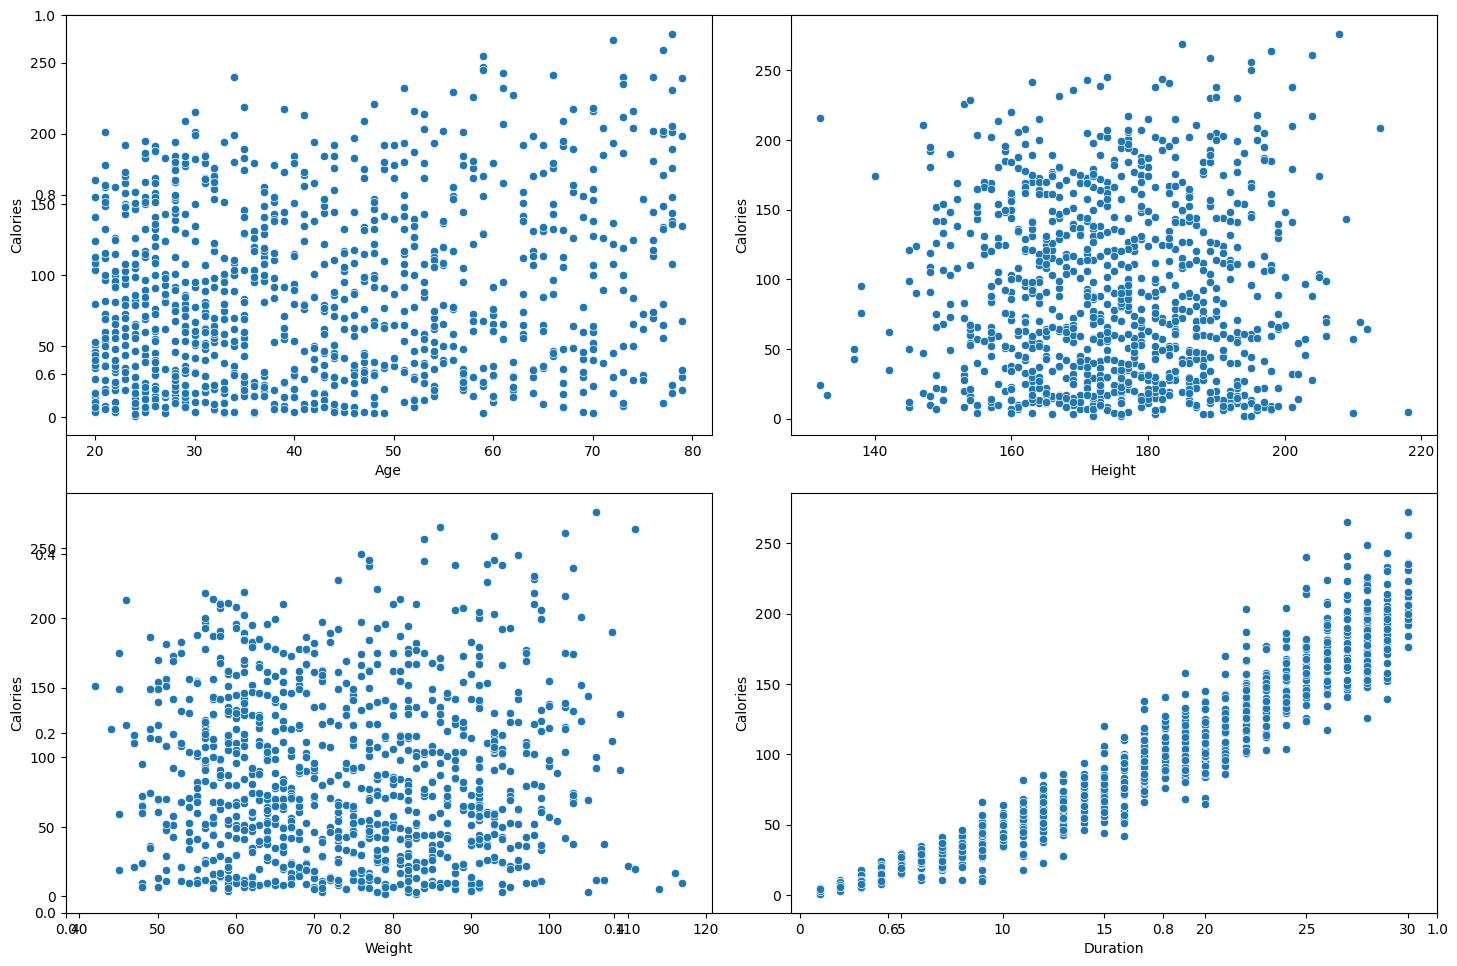

In [4]:
features = ['Age', 'Height', 'Weight', 'Duration']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    x = df.sample(1000)
    sb.scatterplot(x=col, y='Calories', data=x)
plt.tight_layout()
plt.show()

# This code is modified by Susobhan Akhuli

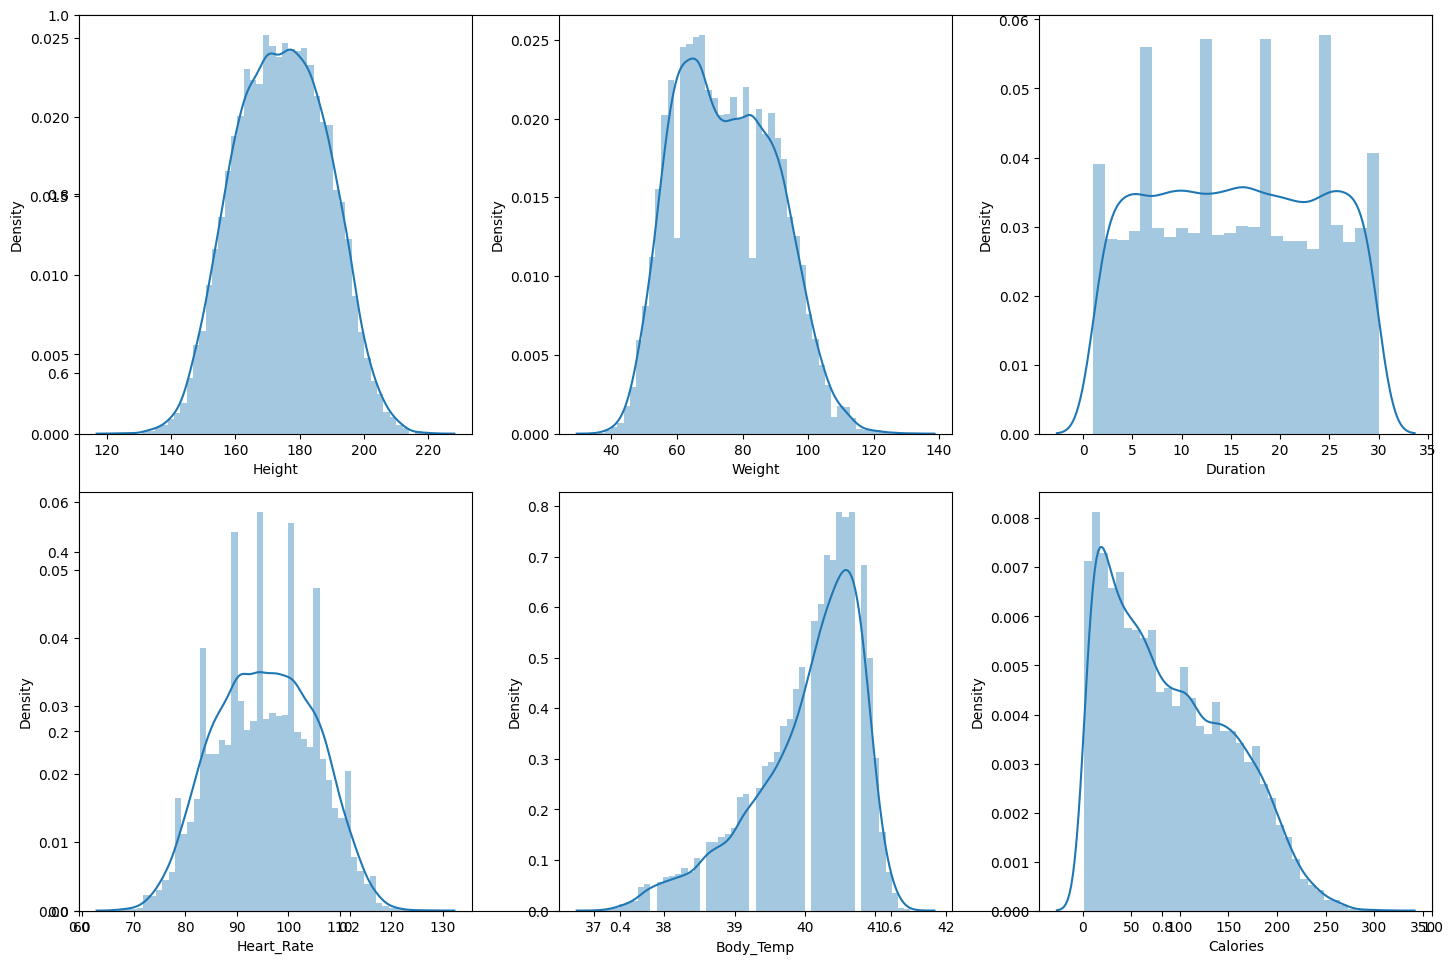

In [5]:
features = df.select_dtypes(include='float').columns

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [6]:
df.replace({'male': 0, 'female': 1},
           inplace=True)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


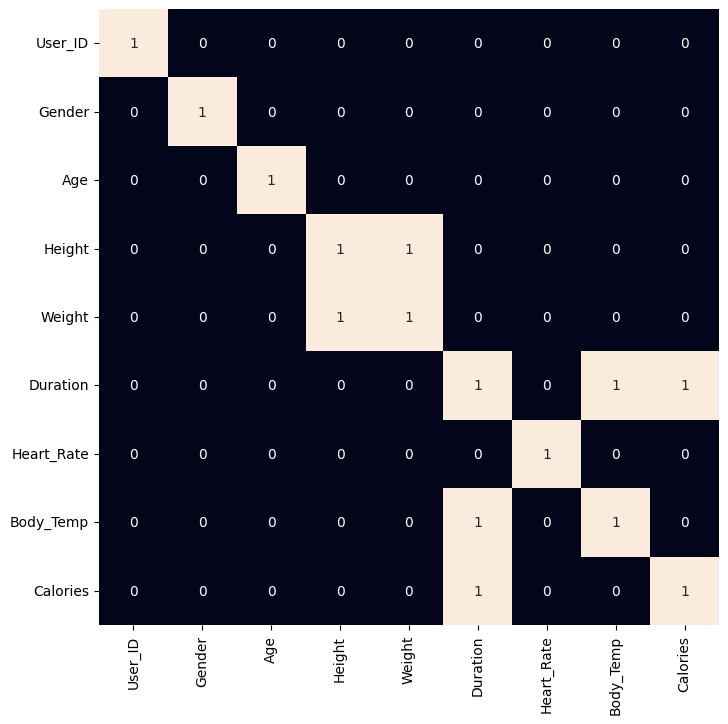

In [7]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.9,
           annot=True,
           cbar=False)
plt.show()

In [8]:
to_remove = ['Weight', 'Duration']
df.drop(to_remove, axis=1, inplace=True)

In [9]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((13500, 5), (1500, 5))

In [10]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(), RandomForestRegressor()]

for i in range(len(models)):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  17.893463692619434
Validation Error :  18.007896272831253

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  7.89463304294701
Validation Error :  10.12050432946533

RandomForestRegressor() : 
Training Error :  3.98020046031746
Validation Erro

In [13]:
import joblib

# Save the trained XGBoost model (index 1 in the models list)
joblib.dump(models[1], 'model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


In [15]:
import gradio as gr
import joblib
import numpy as np

# Load your pre-trained model (make sure the file is in the same directory or provide the full path)
try:
    with open("model.pkl", "rb") as file:
        model = joblib.load(file)
except Exception as e:
    raise FileNotFoundError("Model file not found. Make sure 'model.pkl' exists.") from e

# Load the scaler as well
try:
    with open("scaler.pkl", "rb") as file:
        scaler = joblib.load(file)
except Exception as e:
    raise FileNotFoundError("Scaler file not found. Make sure 'scaler.pkl' exists.") from e


def predict_calories(gender, age, height, heart_rate, body_temp):
    """
    Predict the number of calories burnt based on the provided inputs.

    Parameters:
        gender (str): Gender of the individual ('Male' or 'Female').
        age (float): Age of the individual.
        height (float): Height in centimeters.
        heart_rate (float): Average heart rate during exercise.
        body_temp (float): Body temperature in Celsius.

    Returns:
        float: Predicted calories burnt.
    """
    # Convert gender string to numerical representation (0 for male, 1 for female)
    gender_numeric = 0 if gender == 'Male' else 1

    # Preprocess the input as required by your model
    # Example: Creating a 2D numpy array for a single prediction instance.
    input_data = np.array([[gender_numeric, age, height, heart_rate, body_temp]])

    # Scale the input data using the loaded scaler
    scaled_input_data = scaler.transform(input_data)

    # Get the model prediction (modify if your model outputs need inverse scaling)
    prediction = model.predict(scaled_input_data) # Using the loaded model directly

    # Assuming the model outputs a single value prediction.
    return prediction[0]

# Define the input components for Gradio
inputs = [
    gr.Radio(["Male", "Female"], label="Gender"),
    gr.Number(label="Age", value=30),
    gr.Number(label="Height (cm)", value=170),
    gr.Number(label="Average Heart Rate (bpm)", value=120),
    gr.Number(label="Body Temperature (°C)", value=37)
]

# Define the output component; in this case, it's a number showing the predicted calories burnt.
output = gr.Number(label="Predicted Calories Burnt")

# Create a Gradio Interface
interface = gr.Interface(
    fn=predict_calories,
    inputs=inputs,
    outputs=output,
    title="Calorie Burn Prediction",
    description=("Enter your exercise parameters and personal details to predict "
                 "the number of calories burnt during your workout. Ensure the model "
                 "file 'model.pkl' and scaler file 'scaler.pkl' are correctly loaded.")
)

# Launch the Gradio UI
if __name__ == "__main__":
    interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0270779e93c92a482d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
df.head()